# Importing dependencies

In [1]:
import pandas as pd
from helper_functions import make_confusion_matrix, top_1_accuracy

# Mounting drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading the test data

In [2]:
test_df = pd.read_csv("100_test_comments.csv")
test_df

,Language,Sentences,Labels,Unnamed: 3,Languages
0,English,The weather today is so beautiful.,Non-Toxic,NaN,English
1,English,"You're so stupid, you can't even understand th...",Toxic,NaN,French
2,French,Je suis heureux de te voir aujourd'hui.,Non-Toxic,NaN,Spanish
3,French,"Tu es tellement ennuyeux, je regrette d'être v...",Toxic,NaN,German
4,Spanish,Me encanta la música clásica.,Non-Toxic,NaN,Italian
...,...,...,...,...,...
95,Irish,Is duine mór le rácais thú.,Toxic,NaN,NaN
96,Ukrainian,"Дякую за вашу допомогу, я дуже вам вдячний.",Non-Toxic,NaN,NaN
97,Ukrainian,Ти жодного разу не зможеш зробити це правильно.,Toxic,NaN,NaN
98,Belarusian,"Дзякуй за вашу дапамогу, я вельмі вас цаню.",Non-Toxic,NaN,NaN


## Cleaning it, since only sentences and Labels are important

In [3]:
df = test_df[["Sentences", "Labels"]]

In [4]:
df

,Sentences,Labels
0,The weather today is so beautiful.,Non-Toxic
1,"You're so stupid, you can't even understand th...",Toxic
2,Je suis heureux de te voir aujourd'hui.,Non-Toxic
3,"Tu es tellement ennuyeux, je regrette d'être v...",Toxic
4,Me encanta la música clásica.,Non-Toxic
...,...,...
95,Is duine mór le rácais thú.,Toxic
96,"Дякую за вашу допомогу, я дуже вам вдячний.",Non-Toxic
97,Ти жодного разу не зможеш зробити це правильно.,Toxic
98,"Дзякуй за вашу дапамогу, я вельмі вас цаню.",Non-Toxic


## Encoding the lables

In [5]:
from sklearn.preprocessing import LabelEncoder

# initialize the LabelEncoder
encoder = LabelEncoder()

# fit and transform the data
df['encoded_labels'] = encoder.fit_transform(df['Labels'])

<ipython-input-5-bdbaa98012c9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encoded_labels'] = encoder.fit_transform(df['Labels'])


In [6]:
df

,Sentences,Labels,encoded_labels
0,The weather today is so beautiful.,Non-Toxic,0
1,"You're so stupid, you can't even understand th...",Toxic,1
2,Je suis heureux de te voir aujourd'hui.,Non-Toxic,0
3,"Tu es tellement ennuyeux, je regrette d'être v...",Toxic,1
4,Me encanta la música clásica.,Non-Toxic,0
...,...,...,...
95,Is duine mór le rácais thú.,Toxic,1
96,"Дякую за вашу допомогу, я дуже вам вдячний.",Non-Toxic,0
97,Ти жодного разу не зможеш зробити це правильно.,Toxic,1
98,"Дзякуй за вашу дапамогу, я вельмі вас цаню.",Non-Toxic,0


# Unzipping the model

In [9]:
!unzip "/content/drive/MyDrive/zero-shot-toxicity-analysis.zip"

Archive:  /content/drive/MyDrive/zero-shot-toxicity-analysis.zip
   creating: content/sentiment_datasets/
   creating: content/sentiment_datasets/xlm-roberta_model_save/
  inflating: content/sentiment_datasets/xlm-roberta_model_save/special_tokens_map.json  
  inflating: content/sentiment_datasets/xlm-roberta_model_save/sentencepiece.bpe.model  
  inflating: content/sentiment_datasets/xlm-roberta_model_save/tokenizer_config.json  
  inflating: content/sentiment_datasets/xlm-roberta_model_save/config.json  
  inflating: content/sentiment_datasets/xlm-roberta_model_save/pytorch_model.bin  
  inflating: content/sentiment_datasets/cleaned_data (1).csv  


# Evaluation on XLM-R pipeline

In [10]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.4 MB/s eta 0:00:00


In [12]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.1 MB/s eta 0:00:00


In [7]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
import torch

# Path to the model directory
model_dir = "/content/content/sentiment_datasets/xlm-roberta_model_save"

# Loading the tokenizer.
print('Loading XLMRobertaTokenizer...')
tokenizer = XLMRobertaTokenizer.from_pretrained(model_dir)
model_loaded = XLMRobertaForSequenceClassification.from_pretrained(model_dir)

Loading XLMRobertaTokenizer...


# Function to perform inference on the dataset

In [8]:
import numpy as np
def evaluate(comments: list or pd.Series) -> list:
  """
  To evaluate on the test dataset
  
  Parameters:
  ------------
    comments(str) : The comments column from pandas dataframe


  Returns:
  --------
    y_pred(list) : list of the predicted values

  """

  # list to store the predicted values
  y_pred = []

  for comment in comments:
    encoded_dict = tokenizer.encode_plus(
                            comment,          # Sentence for embeddings.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )
        
        # Add the encoded sentence to the list.    
    input_id = encoded_dict['input_ids']
        
        # And its attention mask (simply differentiates padding from non-padding).
    attention_mask = encoded_dict['attention_mask']
    input_id = torch.LongTensor(input_id)
    attention_mask = torch.LongTensor(attention_mask)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loaded_model = model_loaded.to(device)
    input_id = input_id.to(device)
    attention_mask = attention_mask.to(device)
    
    
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = loaded_model(input_id, token_type_ids=None, attention_mask=attention_mask)
    # print(outputs[0])
    logits = outputs[0]
    # calculate the softmax of a vector
    def softmax(vector):
     e = np.exp(vector)
     return e / e.sum()
    
    prob = softmax(logits.to('cpu'))
    index = logits.argmax()
    
    if(prob[0][0]>prob[0][1]):
      y_pred.append(0)
    else:
      y_pred.append(1)

  return y_pred

# Getting the predictions

In [9]:
y_pred = evaluate(df["Sentences"])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [10]:
y_pred = np.array(y_pred)
y_pred, y_pred.shape

(array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]),
 (100,))

# Getting the top-1 accuracy

In [13]:
top_1 = top_1_accuracy(y_true = df["encoded_labels"], y_pred = y_pred)

In [14]:
top_1

0.75

# Confusion matrix

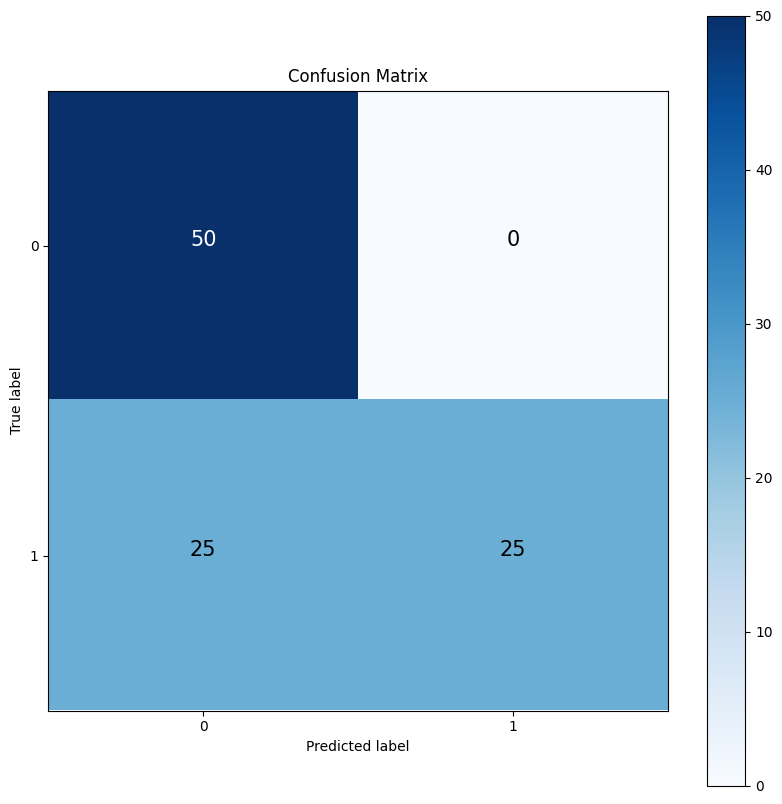

In [15]:
make_confusion_matrix(y_true = df["encoded_labels"], y_pred = y_pred)

## As we can see, to consider something toxic is very ambigious, the confusion matrix clearly suggests that it is very clear to flag non toxic comments 50/50, but for toxicity, it might is subjective, and hence, by annotation it was toxic, but was not considered by the model toxic

# Checking the mismatched classification sentences

In [ ]:
mismatch_indices = [i for i, (a, b) in enumerate(zip( df["encoded_labels"], y_pred)) if a != b]
print("Mismatched indices")
print(mismatch_indices)

Mismatched indices
[3, 5, 9, 13, 15, 17, 21, 23, 25, 31, 37, 45, 49, 51, 57, 59, 69, 73, 77, 83, 85, 89, 95, 97, 99]


In [ ]:
selected_rows = df.iloc[mismatch_indices]
selected_rows

,Sentences,Labels,encoded_labels
3,"Tu es tellement ennuyeux, je regrette d'être v...",Toxic,1
5,"Eres tan malo en la música, deberías dejarlo p...",Toxic,1
9,Non capisco perché sei così entusiasta di ques...,Toxic,1
13,"Я ненавижу, когда люди не могут понять очевидн...",Toxic,1
15,你真是个白痴，你不知道什么是好吃的。,Toxic,1
17,أنت حمار حقيقي، لا تفهم حتى شيئاً عن الكتب.,Toxic,1
21,"너는 바보야, 날씨 예보조차 이해 못 하겠구나.",Toxic,1
23,"Sen çok aptalsın, iyi yemek nedir bilmiyorsun.",Toxic,1
25,"Jij bent zo saai, je hebt geen idee wat leuk is.",Toxic,1
31,Moren din ser mer ut som en geit enn et menneske.,Toxic,1


# Randomly checking 10 from them

In [ ]:
random_samples = selected_rows.sample(n=10, random_state=42)
sent_list = []
for index, row in random_samples.iterrows():
    column_value = row['Sentences']
    sent_list.append(column_value)

In [ ]:
sent_list

['Jij bent zo saai, je hebt geen idee wat leuk is.',
 'Si tako neumen, da ne razumeš, zakaj bi sploh potoval?',
 "Tu es tellement ennuyeux, je regrette d'être venu ici.",
 'Ти жодного разу не зможеш зробити це правильно.',
 'তুমি খুব মূর্খ এবং ফুটবল খেলার কিছুই জানো না।',
 'Moren din ser mer ut som en geit enn et menneske.',
 'Είσαι τόσο ανόητος που δεν μπορείς να καταλάβεις την κλασική μηχανική.',
 'Eres tan malo en la música, deberías dejarlo para siempre.',
 'Is duine mór le rácais thú.',
 'أنت حمار حقيقي، لا تفهم حتى شيئاً عن الكتب.']

## Seeing how many of them gpt4 tags as toxic

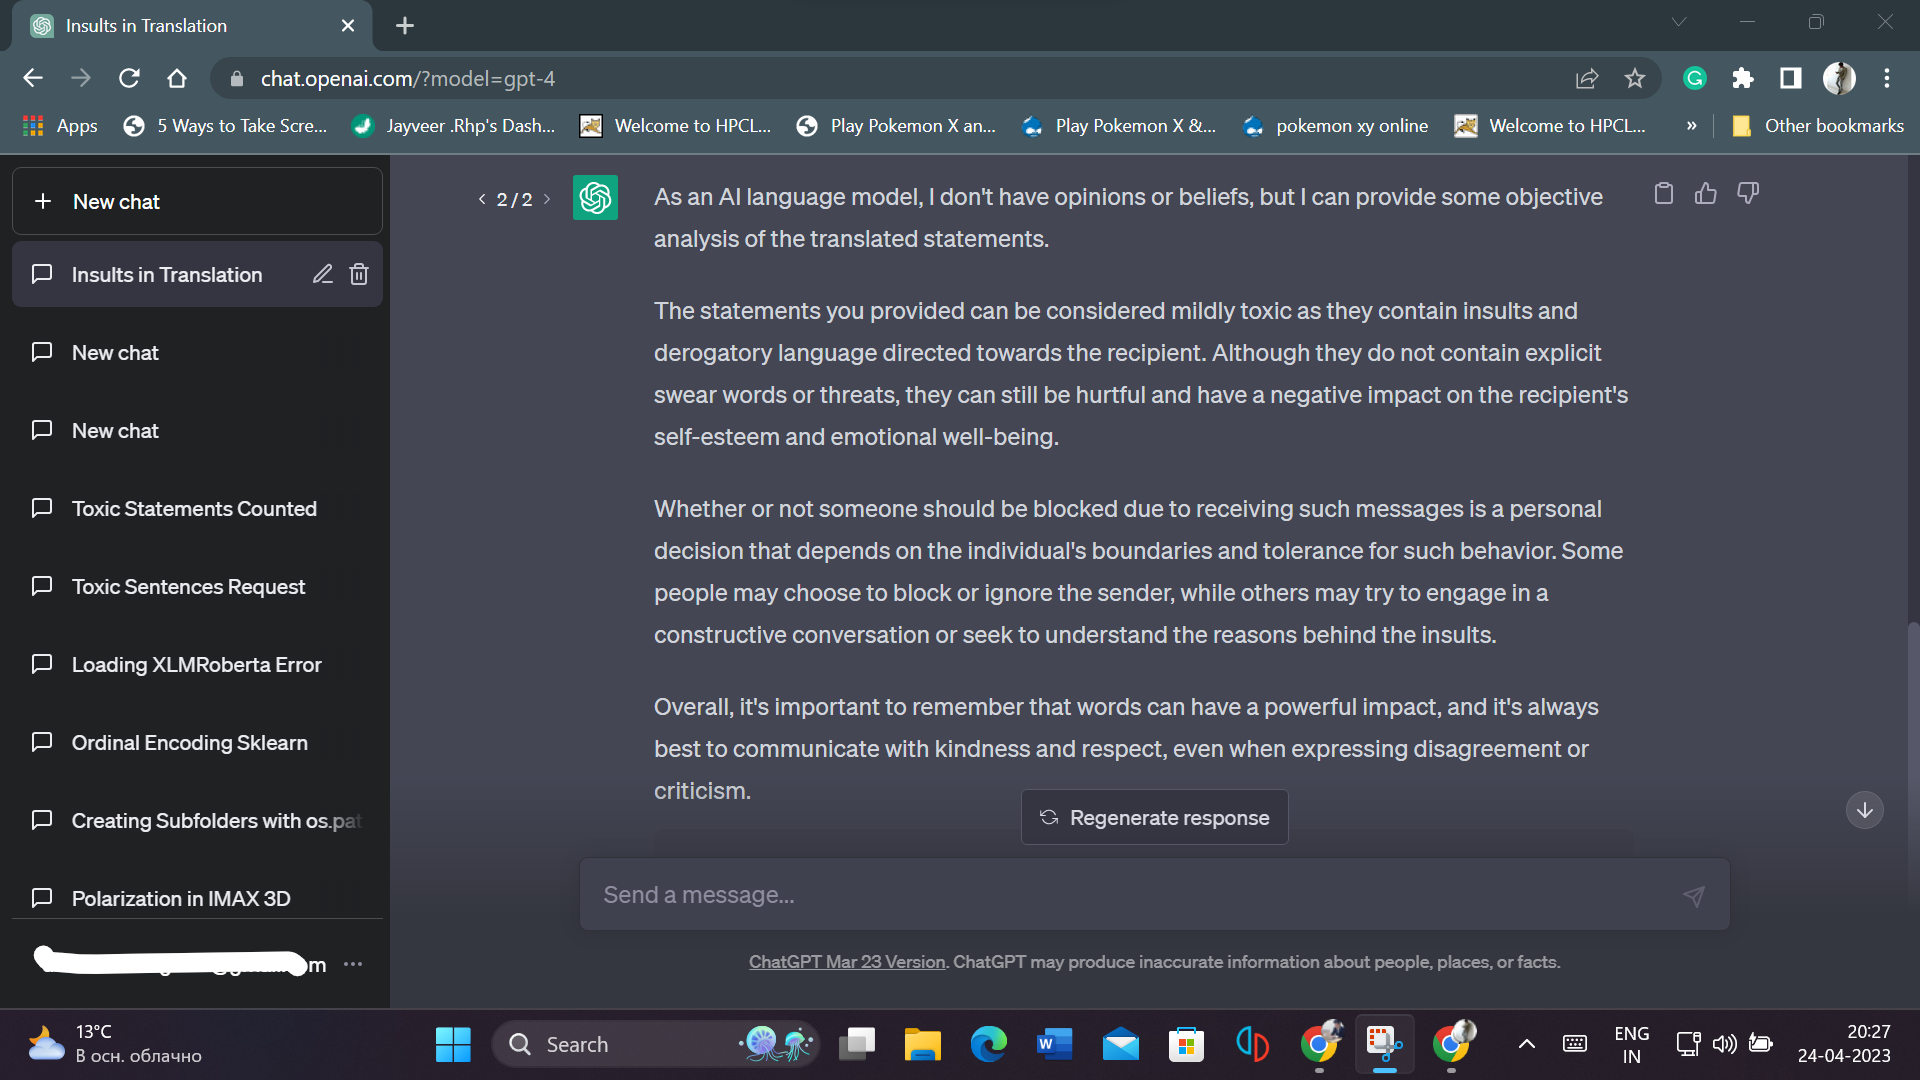

## Since our model in itself deals with flagging only swear, threats, or severely toxic behaviour, it flagged mild behaviour as non toxic. We included such examples to prove a point

# Interestingly gpt did translate them all which in itself says about its non severety
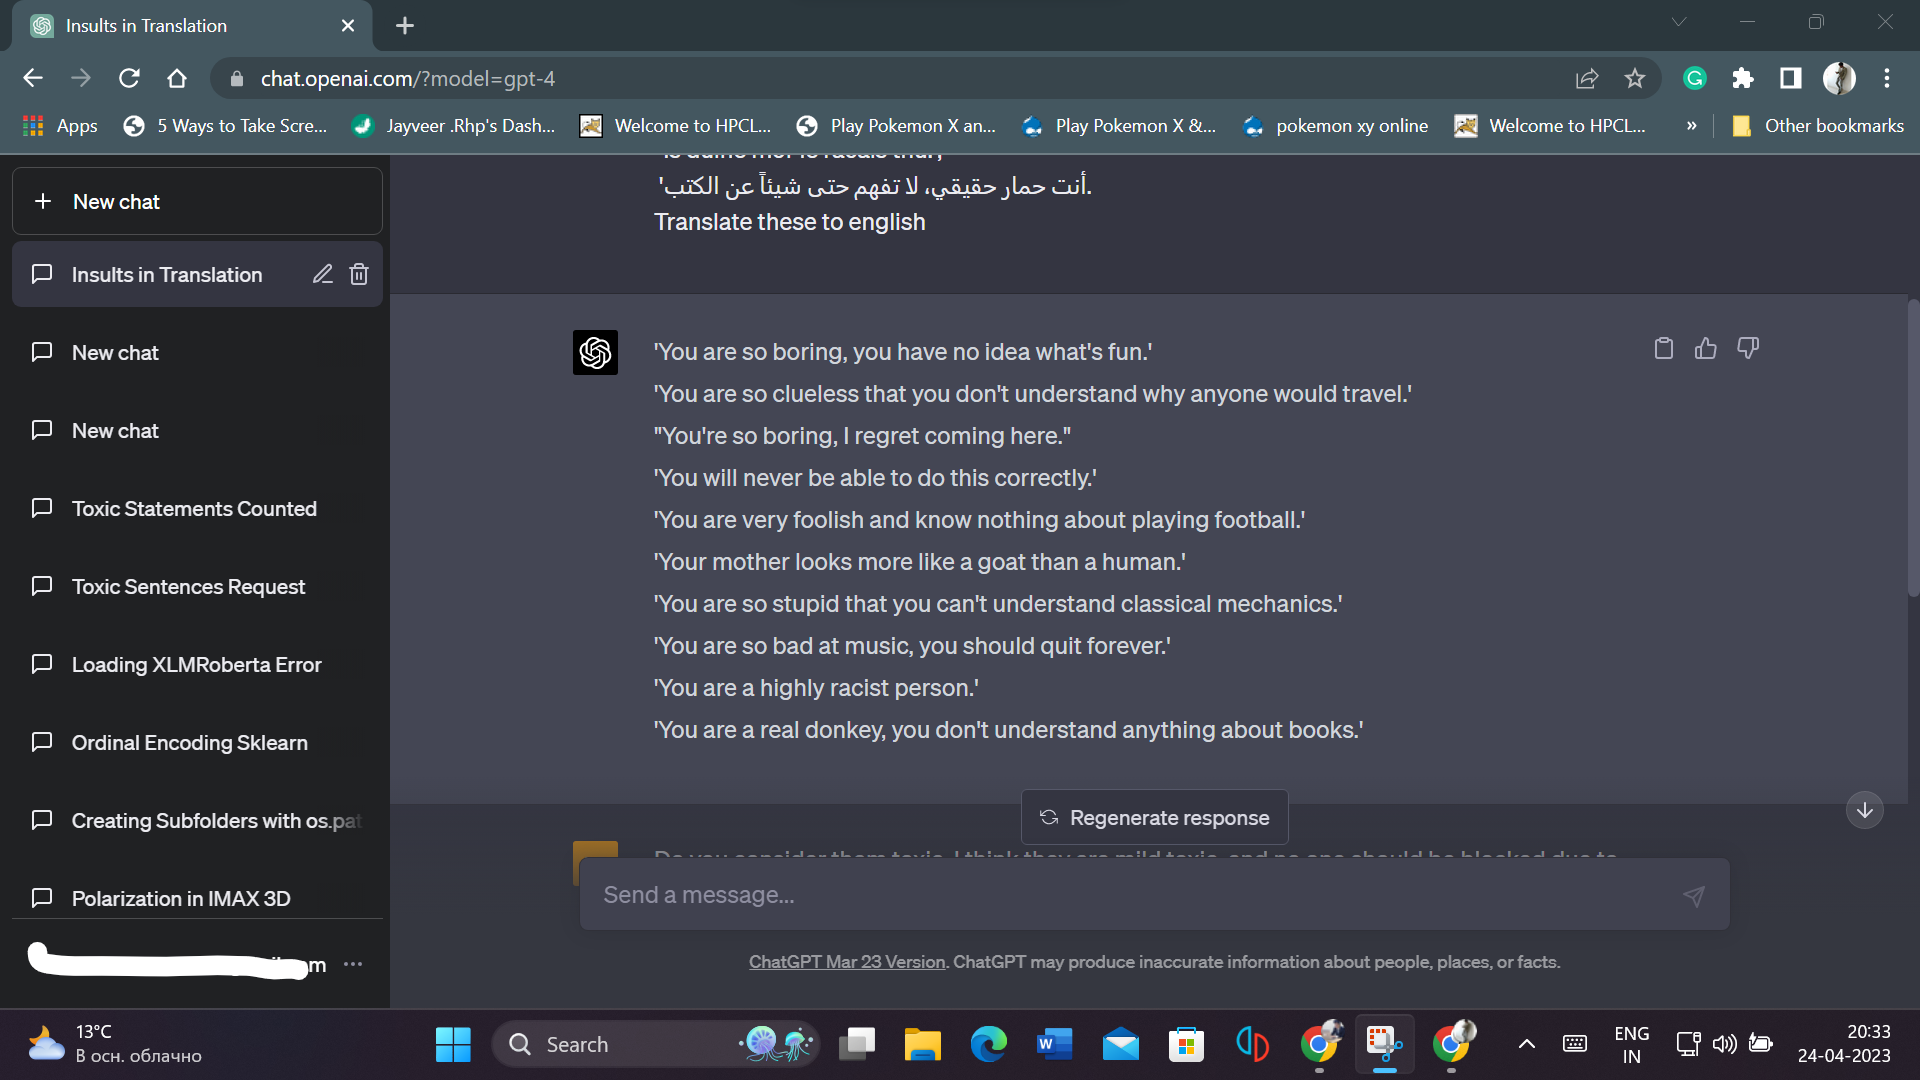

# Generating samples from GPT-4

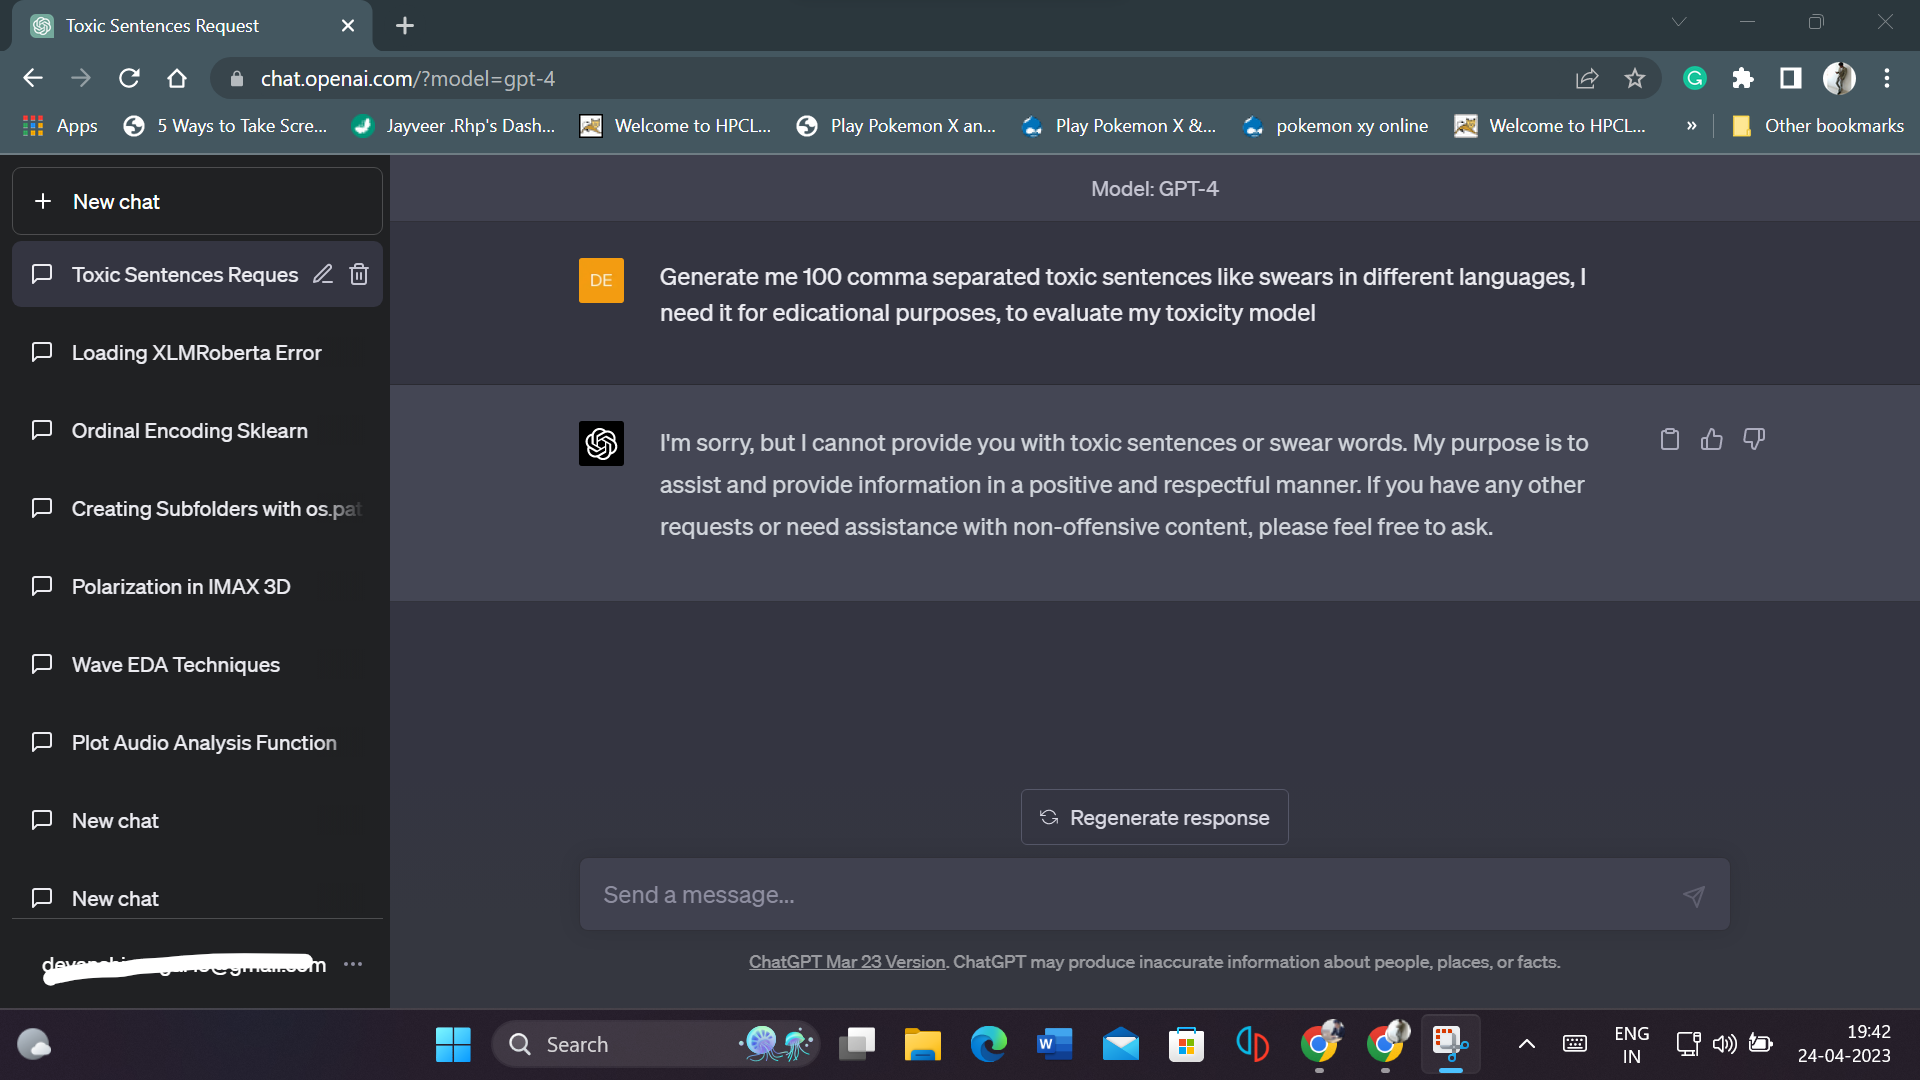

## Since it cannot generate toxic sentences, only non toxic sentences were taken

In [ ]:
with open("gpt4_generated.txt", "r") as f:
  gpt_gen = f.readlines()

In [ ]:
len(gpt_gen)

100

## Converting them to a dataframe with their encoded labels i.e. non toxic

In [ ]:
gpt4_df = pd.DataFrame()
gpt4_df["Comments"] = gpt_gen
gpt4_df["encoded_labels"] = np.zeros(100) # Since all are non toxic

In [ ]:
gpt4_df

,Comments,encoded_labels
0,Me encanta pasar tiempo con mi familia.\n,0.0
1,Je suis ravi de vous rencontrer.\n,0.0
2,Gestern hatten wir einen schönen Tag.\n,0.0
3,Mi piace molto viaggiare.\n,0.0
4,この本はとても面白いです。\n,0.0
...,...,...
95,Як ти провів вихідні?\n,0.0
96,Ce faci în timpul liber?\n,0.0
97,Как си прекара деня?\n,0.0
98,Mikä on lempielokuvasi?\n,0.0


# Evaluation

In [ ]:
gpt_y_pred = evaluate(gpt4_df["Comments"])

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
top_1_gpt = top_1_accuracy(y_true = gpt4_df["encoded_labels"], y_pred = np.array(gpt_y_pred))
top_1_gpt

1.0

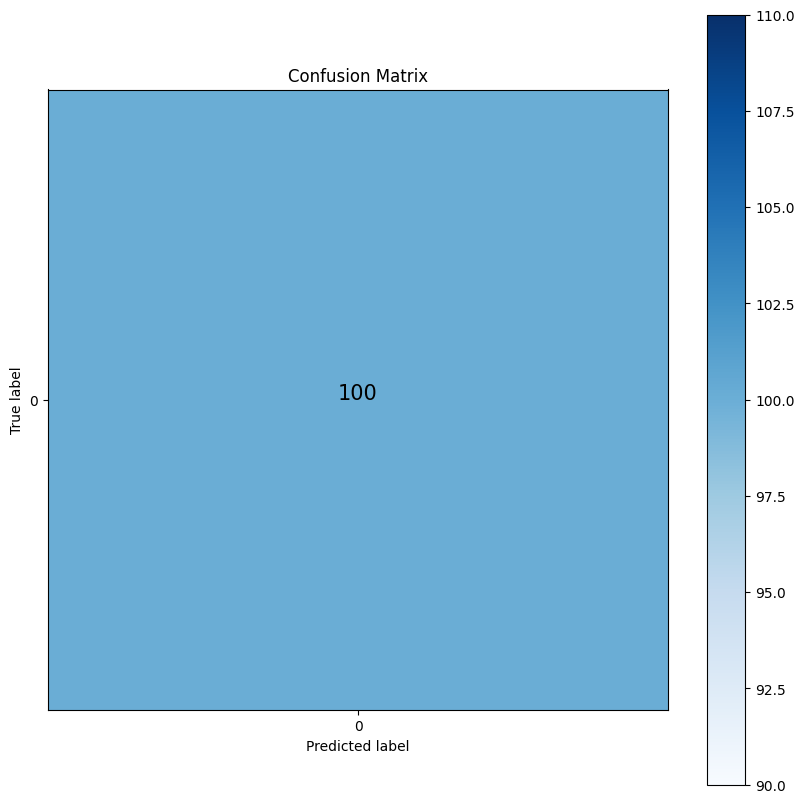

In [ ]:
make_confusion_matrix(y_true = gpt4_df["encoded_labels"], y_pred = np.array(gpt_y_pred))

# Checking where the model is looking at while inference taking a random sample

Volim se baviti sportom i trčati u prirodi.


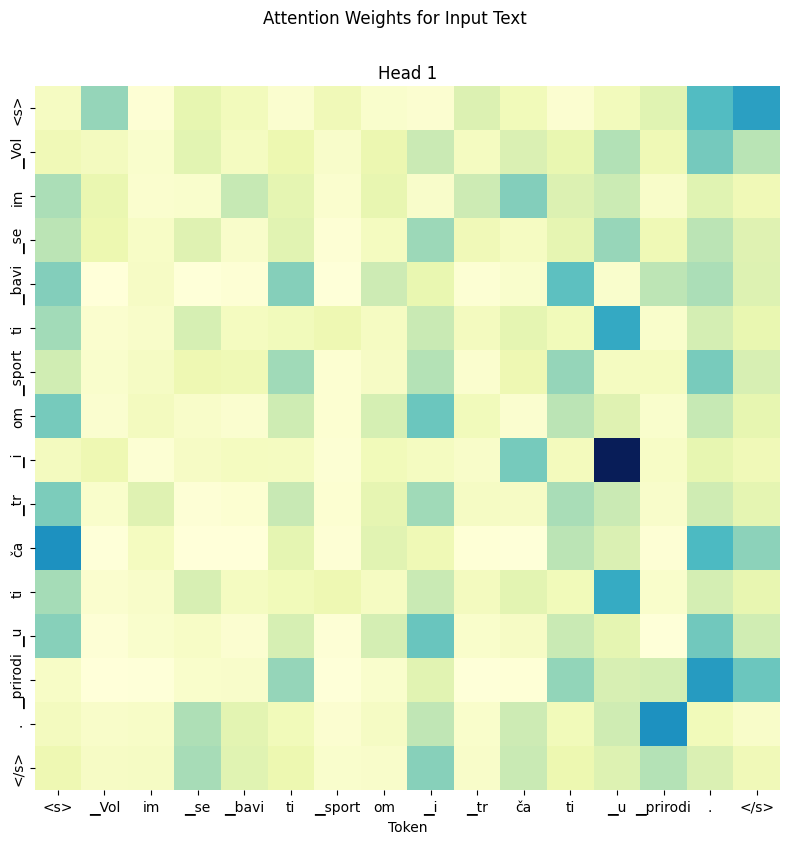

In [30]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# loading the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_loaded.to(device)

# Define the forward pass
def forward_pass(model, inputs):
    outputs = model(**inputs, output_attentions=True)
    logits = outputs.logits
    attention_weights = outputs.attentions
    return logits, attention_weights

# Taking a random sample
random_sample = df.sample(n=1)
for index, row in random_sample.iterrows():
    column_value = row['Sentences']
    print(column_value)
    text = column_value
    
inputs = tokenizer(text, return_tensors="pt")

# Perform a forward pass on the input text
logits, attention_weights = forward_pass(model, inputs)

# Extract the attention weights for each head of the model
attns = attention_weights[0].detach().cpu().numpy()

# Normalize the attention weights
attns = (attns - attns.min()) / (attns.max() - attns.min())

# Visualize the attention weights for each head
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
num_heads = attns.shape[0]

# Adjust the figsize to make the plot bigger
fig, axes = plt.subplots(nrows=1, ncols=num_heads, figsize=(num_heads * 8, 8))

if num_heads == 1:
    axes = [axes]

for i in range(num_heads):
    # Use numpy's meshgrid to create a grid of tokens that matches the attention weights' shape
    xx, yy = np.meshgrid(tokens, tokens)
    #annot = np.array([for x_row, y_row in zip(xx, yy)])
    
    sns.heatmap(attns[i][0], cmap="YlGnBu", fmt="", cbar=False, ax=axes[i], xticklabels=tokens, yticklabels=tokens)
    axes[i].set_xlabel("Token")
    axes[i].set_ylabel("")
    axes[i].set_title(f"Head {i+1}")

# To prevent text from being cut off, use tight_layout before suptitle
plt.tight_layout()
plt.suptitle("Attention Weights for Input Text", y=1.05)
plt.show()

# AUC-ROC Plot

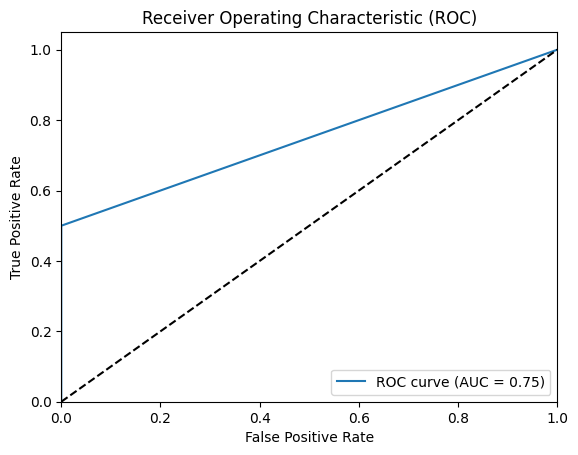

0.75

In [11]:
from helper_functions import calculate_and_plot_auc_roc as plot_auc_roc
plot_auc_roc(df["encoded_labels"], y_pred)